# Cropland monthly vegetation condition anomalies

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls7_sr](https://explorer.digitalearth.africa/ls7_sr), [crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern)

## Background
Understanding how the vegetated landscape responds to longer-term environmental drivers such as the El Nino Southern Oscillation (ENSO) or climate change, requires the calculation of seasonal anomalies. Standardised seasonal anomalies subtract the long-term seasonal mean from a time-series and then divide the result by the long-term standard deviation, thus removing seasonal variability and highlighting change related to longer-term drivers.


### Description

This notebook will calculate seasonal _standardised_ NDVI anomalies for any given season and year. The long-term seasonal climatologies (both mean and standard deviation) are calculated on-the-fly.
        
\begin{equation}
\text{Standardised anomaly }=\frac{x-m}{s}
\end{equation}

$x$ is the seasonal mean, $m$ is the long-term mean, and $s$ is the long-term standard deviation.

**Note:** It is a convention to establish climatologies based on a 30-year time range to account for inter-annual and inter-decadal modes of climate variability (often 1980&ndash;2010 or 1960&ndash;1990). As the Landsat archive over Africa is not consistent before 2000, the climatologies here have been calculated using the date-range 1999&ndash;2019 (inclusive). While this is not ideal, a 20-year climatology should suffice to capture the bulk of inter-annual and inter-decadal variability; for example, both a major El Nino (2015/16) and a major La Nina (2011) are captured by this time-range.

The following steps are taken in the notebook:

1. Load cloud-masked Landsat data over the region of interest for the years over which the climatologies will be computed
2. Create a map of clear-pixel counts
3. Calculate the NDVI long-term mean and long-term standard deviation
4. Calculate standardised NDVI anomalies
5. Focus on agricultural regions using the DE Africa cropland extent map
6. Plot the results

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils import masking

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",
/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46125 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 3 Memory: 28.14 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

### Analysis parameters

The following cell sets important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.2` or lower.
* `time_range`: The date range over which the NDVI climatolgies will be calculated (e.g. `('1999', '2019') `)
* `year`: The year for which we will calculate the standardised anomaly, e.g. `'2021'`
* `month`: The month for which we will calculate the standardised anomaly, e.g `'January'`,`'February'` etc.
* `resolution`: The x and y cell resolution of the satellite data, e.g. `(-30, 30)` will load Landsat data at its native 30 x 30m resolution
* `dask_chunks`:  the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Landsat data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products).


In [4]:
# Define the area of interest
lat, lon = 12.4917, 37.7649 #near Lake Tana, Ethiopia
buffer = 0.2

# Set the range of dates for the climatology
time_range = ('1999', '2019')

# year and month for anomaly
year = '2021'
month = 'July'

# some final specifications
resolution = (-30, 30)
dask_chunks = dict(x=1000,y=1000)

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

### Define a function for filtering data to the month of interest

In [6]:
months = {'January': [1],
           'February': [2],
           'March': [3],
           'April': [4],
           'May': [5],
           'June': [6],
           'July': [7],
           'August': [8],
           'September': [9],
           'October': [10],
           'November': [11],
           'December': [12]
          }

def filter_month(dataset):
    dss = []
    if dataset.time.begin.month in months[month]:
        dss.append(dataset)
    return dss

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).

The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [7]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red','nir', 'pixel_quality'],
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'dask_chunks':dask_chunks
}

# Load available data Landsat 8
ds = load_ard(dc=dc, 
              products=['ls7_sr','ls8_sr'], 
              group_by='solar_day',
              predicate=filter_month,
              mask_filters=[("opening", 3),("dilation", 3)], #improve cloud-mask
              **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_sr
    ls8_sr
Filtering datasets using filter function
Applying morphological filters to pq mask [('opening', 3), ('dilation', 3)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 53 time steps as a dask array


## Generate a clear pixel count summary

This will help us understand how many observations are going into the NDVI climatology calculations. Too few observations might indicate a bias in the climatology. Remember, the role of the climatology is to define 'average' conditions, too few observations will not provide a realistic estimation of the typical conditions.

In [8]:
#create bit flag dictionary
flags_def = ds.pixel_quality.attrs["flags_definition"]
quality_flags = dict(
                cloud="high_confidence", # True where there is cloud
                cloud_shadow="high_confidence",# True where there is cloud shadow 
)

#add the cloud mask to our dataset
ds['cloud_mask'] = masking.make_mask(ds['pixel_quality'], **quality_flags)

# set cloud_mask: True=cloud, False=non-cloud
mask, _= masking.create_mask_value(flags_def, **quality_flags)

#add the cloud mask to our dataset
ds['cloud_mask'] = (ds['pixel_quality'] & mask) != 0

#calculate the number of clear observation per pixel
pq_count = ds.cloud_mask.sum('time').compute()

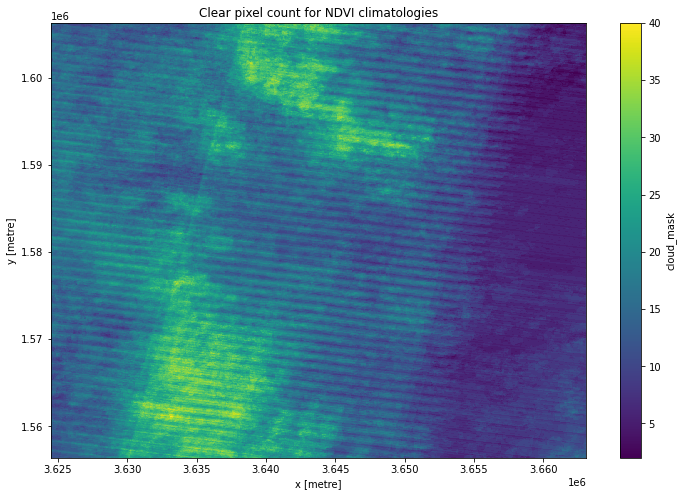

In [9]:
pq_count.plot(size=8)
plt.title('Clear pixel count for NDVI climatologies');

## Calculate NDVI climatologies

This will take a few minutes to run because we will bring the climatologies into memory. Check the Dask dashboard to see progress. Access the dashboard by clicking on the Dashboard link generated when you created the cluster.

In [10]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', collection='c2', drop=True)

#bring into distributed memory to save loading twice
ndvi = ndvi.persist() 

#calculate the climatologies and bring into memory
climatology_mean = ndvi.mean("time").NDVI.compute()
climatology_std = ndvi.std("time").NDVI.compute()

Dropping bands ['red', 'nir', 'pixel_quality', 'cloud_mask']


## Calculate standardised anomalies

Step 1: Load data from the month we're analysing

Step 2. Calculate the mean NDVI during the month

In [11]:
month_query = {
    'x': lon_range,
    'y': lat_range,
    'time': (year+'-'+str(months[month][0])),
    'measurements': ['red','nir'],
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'dask_chunks':dask_chunks
}

# Load available data, Landsat 8 only
month_ds = load_ard(dc=dc, 
              products=['ls8_sr'], 
              group_by='solar_day',
              predicate=filter_month,
              **month_query)

#calculate mean NDVI
month_ndvi = calculate_indices(month_ds, 'NDVI', collection='s2', drop=True)
month_mean = month_ndvi.mean('time').NDVI.compute()

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Filtering datasets using filter function
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 2 time steps as a dask array
Dropping bands ['red', 'nir']


Step 3: Now we can calculate the standardised anomalies by subtracting the long-term mean and dividing by the long-term standard deviation

In [12]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    month_mean,
    climatology_mean,
    climatology_std,
    output_dtypes=[ds.red.dtype],
    dask="allowed"
)

<ipython-input-12-8002fa03a395>:2: RuntimeWarning: divide by zero encountered in true_divide
  lambda x, m, s: (x - m) / s,


## Incorporating DE Africa's cropland extent map

Load the cropland mask over the region of interest. The default analysed here is in Ethiopia, so we need to load the [crop_mask_eastern](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) product, which cover the countries of Ethiopia, Kenya, Tanzania, Rwanda, and Burundi.

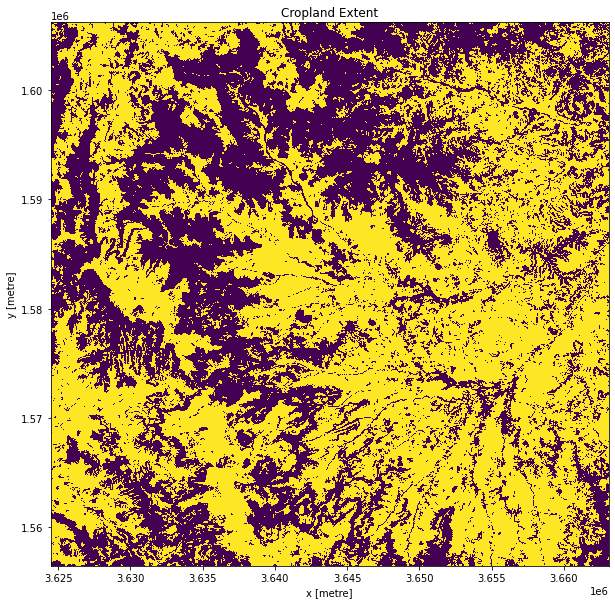

In [13]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(10,10))
plt.title('Cropland Extent');

### Plot NDVI climatolgies, seasonal mean, and anomalies for cropping regions only

Below we mask out the regions that aren't cropping, revealing only the condition of the cropped regions. 

In [14]:
#mask layers with crop-mask
climatology_mean=climatology_mean.where(cm, np.nan)
climatology_std=climatology_std.where(cm, np.nan)
month_mean=month_mean.where(cm, np.nan)
stand_anomalies=stand_anomalies.where(cm, np.nan)

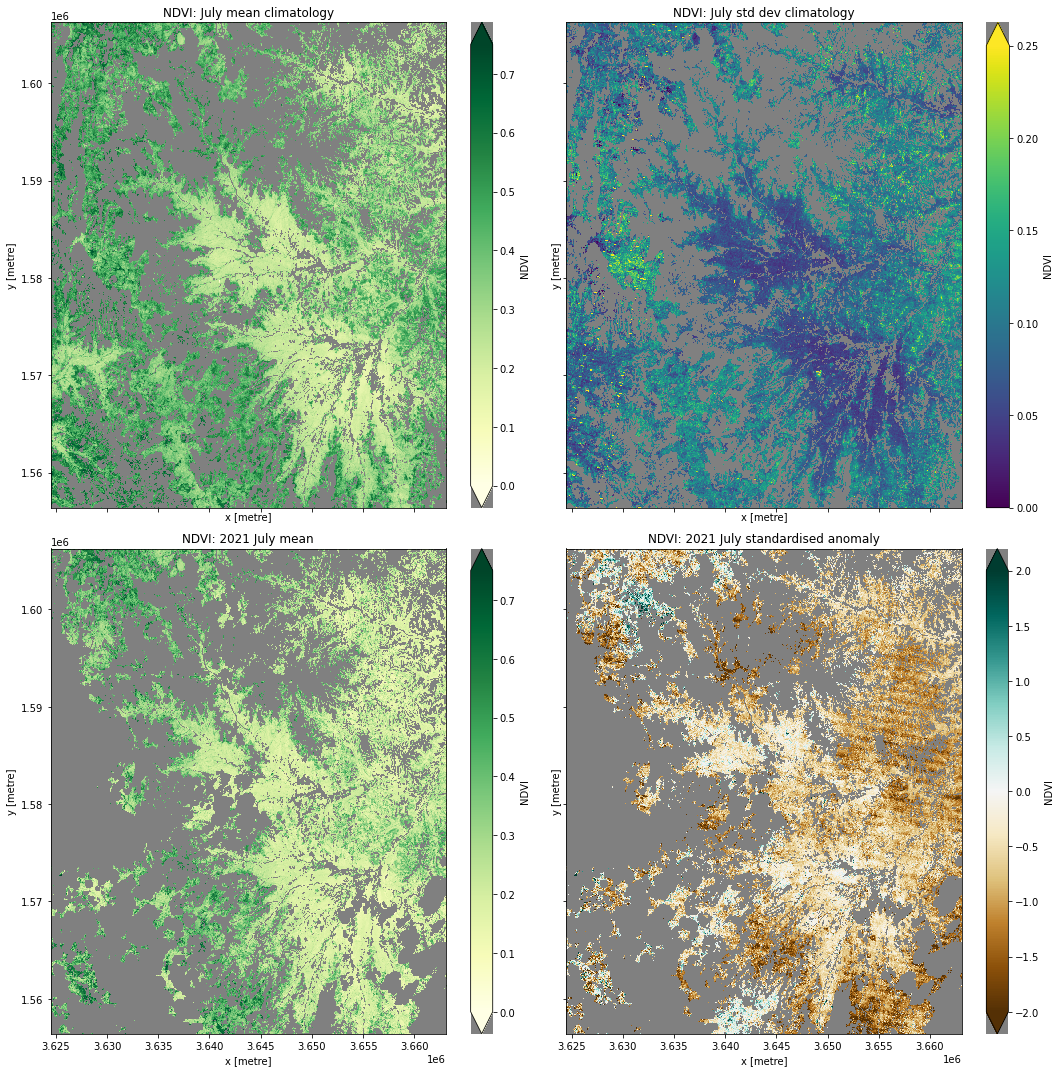

In [15]:
#plot al layers
plt.rcParams['axes.facecolor'] = 'gray' # makes transparent pixels obvious
fig,ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,15))

climatology_mean.plot.imshow(ax=ax[0,0], cmap='YlGn' ,vmin=0, vmax=0.75)
ax[0,0].set_title('NDVI: '+month+' mean climatology')
climatology_std.plot.imshow(ax=ax[0,1], vmin=0, vmax=0.25)
ax[0,1].set_title('NDVI: '+month+' std dev climatology')
month_mean.plot.imshow(ax=ax[1,0], cmap='YlGn', vmin=0, vmax=0.75)
ax[1,0].set_title('NDVI: '+year+" "+month+' mean')
stand_anomalies.plot.imshow(ax=ax[1,1], cmap='BrBG',vmin=-2, vmax=2)
ax[1,1].set_title('NDVI: '+year+" "+month+' standardised anomaly')
plt.tight_layout();

## Drawing Conclusions

Here are some questions to think about:

1. How does the seasonal NDVI mean compare with the long term mean of NDVI?
2. Do the cropping regions tend to have high or low standard deviations in NDVI?
3. Looking at the map of standardised anomalies, are the crops fairing better or worse than average? And how unusual are the anomalies compared with average? 
4. What are other environmental data might help us confirm the drivers of the changes in NDVI?

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-21'